In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from wbfm.utils.feature_detection.class_frame_pair import FramePair
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from wbfm.utils.postures.centerline_pca import WormFullVideoPosture, WormSinglePosture
from wbfm.utils.external.centerline_utils import transform_neuron_point_cloud
import time
from torch.utils.data import DataLoader
import math
from tqdm.auto import tqdm
import wandb
import torch.nn.functional as F
import torch


Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-tracklet_wiggle/project_config.yaml"
fname = "/home/charles/dlc_stacks/worm3-newseg-2021_11_17/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True)

Output files: /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/global2tracklet_manual.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/manually_split_tracklets.h5, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_names.pickle, /home/charles/dlc_stacks/worm3-newseg-2021_11_17/3-tracking/manual_annotation/split_times.pickle
Project data for directory:
/home/charles/dlc_stacks/worm3-newseg-2021_11_17 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: False
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [3]:

fname1 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_X_coords.csv"
fname2 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_Y_coords.csv"
fname3 = "/project/neurobiology/zimmer/wbfm/centerline/wbfm_ulises_centerline_for_charlie/2021-03-04_16-17-30_worm3_ZIM2051-_spline_K.csv"

worm_posture = WormFullVideoPosture(fname1, fname2, fname3)

# Starting from a tracklet, build a batch from nearest neighbor triplets

In [13]:
# Overall metadata
tracklet_names = list(project_data.df_all_tracklets.columns.levels[0])
df_tracklets = project_data.df_all_tracklets

## Do one tracklet first, and just the positive pair

In [20]:
# Local time points, within the tracklet
t0 = 0
t1 = 1

n_neighbors = 100

i_tracklet = 0
tracklet_name = tracklet_names[i_tracklet]
this_tracklet = df_tracklets[tracklet_name]

i_anchor = int(this_tracklet['raw_neuron_id'].iloc[t0])
i_positive = int(this_tracklet['raw_neuron_id'].iloc[t1])


In [21]:
pts0 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t0))
centerline0 = worm_posture.get_centerline_for_time(t0)
worm0 = WormSinglePosture(pts0, centerline0)

pts1 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t1))
centerline1 = worm_posture.get_centerline_for_time(t1)
worm1 = WormSinglePosture(pts1, centerline1)

In [22]:
n0 = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
n1 = worm1.get_neighbors_in_local_coordinate_system(i_anchor=i_positive, n_neighbors=n_neighbors)

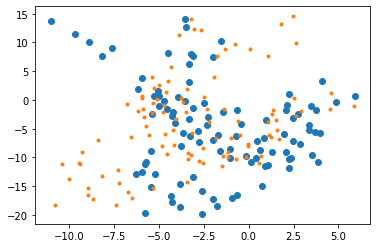

In [23]:
plt.plot(n0[:, 1], n0[:, 2], 'o')
plt.plot(n1[:, 1], n1[:, 2], '.')

# Add negative examples using nearest neighbors of the positive example

In [27]:
batch_sz = 16

num_negative_ind = int(batch_sz / 2)
num_random_ind = num_negative_ind - 1

In [31]:
anchor_pt = worm1.neuron_zxy[i_positive]
negative_pts, negative_ind = worm1.get_neighbors(anchor_pt=anchor_pt, n_neighbors=num_negative_ind)
i_positive

5

In [45]:
def PointCloudTriplets(Dataset):
    
    def __init__(self, t0, t1, n_neighbors, i_tracklet, batch_sz, project_data):
        self.n_neighbors = n_neighbors

        self.batch_sz = batch_sz
        num_negative_ind = int(batch_sz / 2)  # "Hard" examples
        num_random_ind = num_negative_ind  # Random other points
        
        # TODO: switch
        self.t0 = t0
        self.t1 = t1
        self.i_tracklet = i_tracklet
        tracklet_names = list(project_data.df_all_tracklets.columns.levels[0])
        df_tracklets = project_data.df_all_tracklets
        
        tracklet_name = tracklet_names[i_tracklet]
        this_tracklet = df_tracklets[tracklet_name]
        self.this_tracklet = this_tracklet

        i_anchor = int(this_tracklet['raw_neuron_id'].iloc[t0])
        i_positive = int(this_tracklet['raw_neuron_id'].iloc[t1])
        self.i_anchor = i_anchor
        self.i_positive = i_positive
        
        pts0 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t0))
        centerline0 = worm_posture.get_centerline_for_time(t0)
        worm0 = WormSinglePosture(pts0, centerline0)
        self.worm0 = worm0

        pts1 = transform_neuron_point_cloud(project_data.get_centroids_as_numpy(t1))
        centerline1 = worm_posture.get_centerline_for_time(t1)
        worm1 = WormSinglePosture(pts1, centerline1)
        self.worm1 = worm1
        
        n0 = worm0.get_neighbors_in_local_coordinate_system(i_anchor=i_anchor, n_neighbors=n_neighbors)
        n1 = worm1.get_neighbors_in_local_coordinate_system(i_anchor=i_positive, n_neighbors=n_neighbors)
        
        self.n0 = n0
        self.n1 = n1
        
        anchor_pt = worm1.neuron_zxy[self.i_positive]
        negative_pts, negative_ind = worm1.get_neighbors(anchor_pt=anchor_pt, n_neighbors=num_negative_ind)
        self.negative_ind = negative_ind
        # Also add some random examples
        all_ind = list(len(self.worm1.neuron_zxy))
        all_ind.pop(i_positive)
        all_ind.pop(negative_ind)
        random.shuffle(all_ind)
        self.negative_ind.extend(all_ind[:num_random_ind])
    
    def __len__(self):
        return len(self.worm0.neuron_zxy)

    def __getitem__(self, idx):
        # Returns one triplet
        return self.premade_batches[idx]
    
    def _get_triplet(self, idx_negative):
        anchor_cloud = self.n0
        positive_cloud = self.n1
        
        i_negative = self.negative_ind[idx_negative]
        negative_cloud = self.worm1.get_neighbors_in_local_coordinate_system(i_anchor=i_negative, n_neighbors=self.n_neighbors)
        
        return anchor_cloud, positive_cloud, negative_cloud
    
    def custom_collate_fn(self, bundle):
        # Generates a batch from a single anchor, not random anchors
        self.premade_batches = []
        for i in range(len(self)):
            self.premade_batches.append(self._get_triplet(i))
        # return batch

In [46]:
batch_sz = 16
dataset = PointCloudTriplets(t0, t1, n_neighbors, i_tracklet, batch_sz, project_data)

TypeError: PointCloudTriplets() takes 1 positional argument but 6 were given

# Build a network structure

In [ ]:
import os

import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

# The input isn't words, but actually locations, so use a custom encoder that can deal with that
# From: https://github.com/pytorch/examples/blob/master/word_language_model/model.py

class LightningTransformerModel(LightningModule):

    def __init__(self, n_dim_input, ninp, nhead=8, nhid=128, nlayers=6, dropout=0.5, device=None, 
                 learning_rate=2e-4):
        super(LightningTransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        self.learning_rate = learning_rate
        self.src_mask = None
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(n_dim_input, ninp)
        self.ninp = ninp
        # if device is None:
        #     self.device = "cuda:0" if torch.cuda.is_available() else "cpu"

        self.init_weights()
        
        # TODO
        self.criterion = nn.BCELoss()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=False):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None
            
        src = self.encoder(src) * math.sqrt(self.ninp)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        # return F.log_softmax(output, dim=-1)
        return F.softmax(output, dim=-1)

    def training_step(self, batch, batch_idx):
        loss, _ = self._calc_loss(batch)
        self.log("my_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, predictions = self._calc_loss(batch)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        # self.log("val_acc", self.accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def _calc_loss(self, batch):
        x, y = self._unpack_batch_and_pad(batch)
        predictions = self(x)
        loss = self.criterion(predictions, y)
        return loss, predictions
    
    def _unpack_batch_and_pad(self, batch, to_pad=True):
        all_short_x = batch['pt_batch']
        x = []
        for short_x in all_short_x:
            if to_pad:
                num_to_pad = self.ntoken - len(short_x)
                short_x = torch.unsqueeze(torch.from_numpy(np.pad(short_x, ((0, num_to_pad), (0, 0)))), dim=0).float()
            else:
                short_x = torch.from_numpy(short_x).float()
            x.append(short_x)
        x = torch.cat(x)
        match_dict = batch['match_dict']
        y = self._convert_all_matches_to_one_hot(match_dict, to_pad)
        # ref_idx=batch['ref_i']
        return x.to(self.device), y.to(self.device)
    
    
    def _get_valid_ind(self, match_dict):
        valid_ind = []
        for k, v in match_dict.items():
            if not isinstance(k, int):
                continue
            valid_ind.append(torch.from_numpy(v[:, 0]))
        return valid_ind

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        
        # loading the data
        self.train_data = neuron_data_pytorch(train_path, batch_sz=batch_size, shuffle=True, rotate=True, mode=data_mode)
        self.dev_data = neuron_data_pytorch(eval_path, batch_sz=batch_size, shuffle=False, rotate=True, mode=data_mode)

    def train_dataloader(self):
        return DataLoader(self.train_data, shuffle=False, num_workers=1, collate_fn=self.train_data.custom_collate_fn)

    def val_dataloader(self):
        return DataLoader(self.dev_data, shuffle=False, num_workers=1, collate_fn=self.dev_data.custom_collate_fn)

    # def test_dataloader(self):
    #     return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

# Actually train